# Experiments for MNIST Dataset

In [82]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [83]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [84]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [85]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [86]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. They are in the folder \\$root/xai_neurips_2021/models/pre_trained . You can either copy them to the \\$root/xai_neurips_2021/models folder or load them directly from the pre_trained folder (just make sure you use the correct folder).

## Load MNIST dataset

In [87]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [88]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [89]:
# Set train and test size
trainsize = 10048
testsize = 2000

In [90]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 32
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0,trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [91]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False, filename=None, ax=None):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        if ax is None: 
            plt.imshow(npimg, cmap="Greys")
        else:
            ax.imshow(npimg, cmap="Greys")
        plt.tight_layout()
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if not filename is None:
        plt.savefig(filename)

Data samples


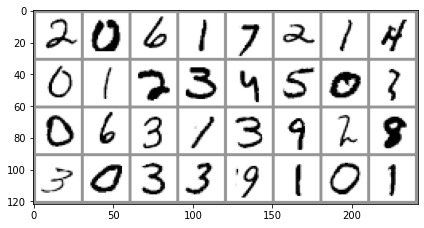

In [92]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# create grid of images
img_grid = torchvision.utils.make_grid(images)

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [93]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, masks, num_classes, output):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
#         print('input', t.shape)
        t = self.conv1(t)
#         print('After conv', t.shape)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
#         print('After max pool', t.shape)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
        
        return t

In [94]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        if not y is None:
            t = torch.cat((t, torch.flatten(y, start_dim=1)), dim=1)
            self.fc1 = nn.Linear(in_features=1*12*12+(self.num_experts* self.num_classes), out_features=15)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [95]:
# create a set of experts
def experts(num_experts, masks, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(masks[i], total_num_classes, num_classes[i]))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [96]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [97]:
# gate covariant shift regularization flag 
w_importance=0.0 

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    plot_file += '_'+specific
    
    return plot_file

In [98]:
def classes_per_expert_str(classes_per_expert):
    buffer_str = ''
    for labels in classes_per_expert:
        buffer = "_".join(str(labels).replace('[','').replace(']','').replace(',','_').replace(" ",'')).replace('_','')
        buffer_str += buffer+'_'
    buffer_str = buffer_str.strip('_')
    return buffer_str

## Experiment 1: Train MoE expectation model with un-trained experts

### The MoE model is first trained with un-trained experts. The gate trained in this model is then used to train a new model with new experts with (a) default parameters and (b) parameters initialized to parameters of the experts that the gate was trained with. 

### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

In [99]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_scratch'
# Model with gate parameters fixed to learnt gate parameters from model_1 and experts initialized to 
# the same initial parameters as experts from model_1 before they were trained
model_2 = 'mnist_pretrained_gate_scratch_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_1 and experts initialized to 
# default parameters
model_3 = 'mnist_pretrained_gate_scratch_rand_wts'

In [100]:
total_experts = 5

In [101]:
num_epochs = 20

In [ ]:
# Train models model_1, model_2 and model_3 for 10 runs
n_runs = 5
n_run_models_1 = []
n_run_models_2 = []
n_run_models_3 = []
for n_run in range(1, n_runs+1):
    print('RUN', n_run)
    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    models_gate_pretrained_same_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    saved_experts = {}

    # Build model with un-trained experts
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with un-trained experts')
        # copy and save the expert models to save the parameters
        expert_models_copy = experts(total_experts, [None]*total_experts, num_classes, 
                                     [num_classes]*total_experts).to(device)

        # copy and save the expert models to save the parameters
        expert_models = deepcopy(expert_models_copy)
        saved_experts[key] = expert_models_copy

        gate_model = gate_layers(total_experts, num_classes).to(device)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    n_run_models_1.append(models)

    # train new experts with pre-trained gate fom model_1 above with same parameters as the 
    # experts it was trained from
    for key, val in models_gate_pretrained_same_wts.items():
        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')
        
        # copy parameters of the experts
        expert_models = deepcopy(saved_experts[key])

        # load the pre-trained gate model
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the parameters of the gate
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    n_run_models_2.append(models_gate_pretrained_same_wts)

    # Train new experts with pre-trained gate fom model_1 above with default parameters
    for key, val in models_gate_pretrained_rand_wts.items():
        
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                [num_classes]*total_experts).to(device)

        # load pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    
    n_run_models_3.append(models_gate_pretrained_rand_wts)

# Save all the trained models
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')
torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))

plot_file = generate_plot_file(model_2, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')
torch.save(n_run_models_2,open(os.path.join(model_path, plot_file),'wb'))

plot_file = generate_plot_file(model_3, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')
torch.save(n_run_models_3,open(os.path.join(model_path, plot_file),'wb'))               

## Experiment 2: Train MoE expectation model with pre-trained experts

### The MoE model is first trained with pre-trained experts trained on pre-defined data splits. The gate trained in this model is then used to train a new model with new experts with (a) default parameters and (b) parameters initialized to parameters of the experts that the gate was trained with. 

### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

#### Pre-defined data splits are each a set of 5 pairs of digits. Each of the 5 experts is trained on data samples of only one of the 5 pairs of the split. We created 5 splits in all for the experiments.

In [62]:
# Pre-defined class split among experts
classes_per_expert_list = [[[0,1], [2,5], [3,4], [6,9], [7,8]],
                      [[0,9], [1,4], [2,7], [3,6], [5,8]],
                      [[0,3], [1,2], [4,7], [5,9], [6,8]],
                      [[0,5], [1,9], [2,6], [3,7], [4,8]],
                      [[0,4],[1,8], [2,9], [3,6], [5,7]]]

class_expert_map = []
for cpe in classes_per_expert_list:
    entry = {c[0]:c[1] for c in cpe}
    class_expert_map.append(entry)

In [63]:
# Function to pre-train experts according to the split
def train_experts(masks, total_experts, num_classes_per_expert, num_classes, num_epochs, batch_size,
                  trainset, testset):
    expert_models_copy = experts(total_experts, masks, num_classes, num_classes_per_expert).to(device)
    expert_models = deepcopy(expert_models_copy)
    
    for mask, expert in zip(masks, expert_models):
        print('Classes', mask)
        indices = []
        for m in mask:
            indices += torch.where(trainset.targets[0:trainsize] == m)[0]
        
        trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(trainset, range(0, trainsize)), indices), 
                                          batch_size=batch_size,
                                          shuffle=True)
        
        optimizer_expert = optim.RMSprop(expert.parameters(),
                                      lr=0.001, momentum=0.9)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )
    pre_trained_expert = 'mnist_pre_trained'
    plot_file = generate_plot_file(pre_trained_expert, str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str(masks)+'_expert_model.pt')
    print(plot_file)
    torch.save([expert_models, expert_models_copy],open(os.path.join(model_path, plot_file),'wb'))
    return expert_models, expert_models_copy

In [64]:
total_experts = 5

In [65]:
num_epochs = 20

In [23]:
# Pre-train experts on pre-defined splits
for class_per_expert in classes_per_expert_list:
    print(class_per_expert)
    expert_models, expert_models_copy = train_experts(class_per_expert, total_experts, [2]*total_experts, num_classes, num_epochs, batch_size,
                      trainset, testset)

[[0, 1], [2, 5], [3, 4], [6, 9], [7, 8]]
Classes [0, 1]
epoch 0 training loss 0.61 , training accuracy 0.77
epoch 1 training loss 0.02 , training accuracy 0.99
epoch 2 training loss 0.01 , training accuracy 1.00
epoch 3 training loss 0.01 , training accuracy 1.00
epoch 4 training loss 0.01 , training accuracy 1.00
epoch 5 training loss 0.01 , training accuracy 1.00
epoch 6 training loss 0.01 , training accuracy 1.00
epoch 7 training loss 0.01 , training accuracy 1.00
epoch 8 training loss 0.01 , training accuracy 1.00
epoch 9 training loss 0.01 , training accuracy 1.00
epoch 10 training loss 0.01 , training accuracy 1.00
epoch 11 training loss 0.00 , training accuracy 1.00
epoch 12 training loss 0.01 , training accuracy 1.00
epoch 13 training loss 0.00 , training accuracy 1.00
epoch 14 training loss 0.00 , training accuracy 1.00
epoch 15 training loss 0.01 , training accuracy 1.00
epoch 16 training loss 0.00 , training accuracy 1.00
epoch 17 training loss 0.00 , training accuracy 1.00


#### NOTE: We have provided expert models already pre-trained with the above class splits

In [24]:
# Model trained with pre-trained experts
model_4 = 'mnist_pretrained_gate_prechosen'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to 
# the same initial parameters as experts from model_4 before they were trained
model_5 = 'mnist_pretrained_gate_prechosen_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to default parameters
model_6 = 'mnist_pretrained_gate_prechosen_rand_wts'

In [25]:
total_experts = 5

In [26]:
num_epochs = 20

In [28]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
pre_trained_expert = 'mnist_pre_trained'
n_split_models_1 = []
n_split_models_2 = []
n_split_models_3 = []
for classes_per_expert in classes_per_expert_list:
    print('RUN for split:', classes_per_expert_str(classes_per_expert))

    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    models_gate_pretrained_same_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    # Load the pre-trained experts for the corresponding split
    plot_file = generate_plot_file(pre_trained_expert, str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str(classes_per_expert)+'_expert_model.pt')
    print(plot_file)
    expert_models, expert_models_copy = torch.load(os.path.join(model_path, plot_file))

    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = expert_models.to(device)

        gate_model = gate_layers(total_experts, num_classes).to(device)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    n_split_models_1.append(models)


    for key, val in models_gate_pretrained_same_wts.items():

        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')

        # copy parameters of the experts
        expert_models = expert_models_copy.to(device)

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    n_split_models_2.append(models_gate_pretrained_same_wts)

    for key, val in models_gate_pretrained_rand_wts.items():
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts, [None]*total_experts, num_classes, [num_classes]*total_experts).to(device)

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model)

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    n_split_models_3.append(models_gate_pretrained_rand_wts)
        
plot_file = generate_plot_file(model_4, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))

plot_file = generate_plot_file(model_5, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(n_split_models_2,open(os.path.join(model_path, plot_file),'wb'))

plot_file = generate_plot_file(model_6, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(n_split_models_3,open(os.path.join(model_path, plot_file),'wb'))


RUN for split: 01_25_34_69_78
mnist_pre_trained_10_5_01_25_34_69_78_expert_model.pt
Model: moe_expectation_model 5 Experts
Building model with pre-trained experts
model params: 35501
epoch 0 training loss 0.58 , training accuracy 0.85 , test accuracy 0.87
epoch 1 training loss 0.26 , training accuracy 0.94 , test accuracy 0.90
epoch 2 training loss 0.20 , training accuracy 0.96 , test accuracy 0.89
epoch 3 training loss 0.16 , training accuracy 0.97 , test accuracy 0.90
epoch 4 training loss 0.15 , training accuracy 0.97 , test accuracy 0.90
epoch 5 training loss 0.13 , training accuracy 0.98 , test accuracy 0.90
epoch 6 training loss 0.11 , training accuracy 0.98 , test accuracy 0.92
epoch 7 training loss 0.11 , training accuracy 0.98 , test accuracy 0.91
epoch 8 training loss 0.10 , training accuracy 0.98 , test accuracy 0.92
epoch 9 training loss 0.09 , training accuracy 0.99 , test accuracy 0.91
epoch 10 training loss 0.09 , training accuracy 0.98 , test accuracy 0.92
epoch 11 trai

## Experiment 3: Train a model with gate coefficient of variation regularization 

### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

In [69]:
total_experts = 5

In [70]:
num_epochs = 20

In [71]:
model_7 = 'mnist_with_reg'

In [ ]:
# Train the MoE model with gate coefficient of variation regularization

# Enable regularization
w_importance = 1.0

print('w_importance', w_importance)
models = {
    'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
    }

for key, val in models.items():
    print('Model:', key, total_experts, 'Experts')
    expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                            [num_classes]*total_experts).to(device)

    gate_model = gate_layers(total_experts, num_classes).to(device)

    moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                             experts=expert_models, gate=gate_model)

    params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
    print('model params:', sum(params))

    optimizer_moe = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                           w_importance=w_importance, accuracy=accuracy, epochs=num_epochs)
    val['experts'][total_experts] = {'model':moe_model, 'history':hist}

plot_file = generate_plot_file(model_7, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(models, open(os.path.join(model_path, plot_file),'wb'))
w_importance = 0.0

## Results

### Plot the confusion matrix for the class predictions, for test data, of the MoE model trained with a linear gate and un-trained linear experts. We plot the results for one of the 10 models we trained.

Model: mnist_scratch_10_5_5_models.pt

Confusion matrix of predictions of the MNIST test data by MoE expectation model


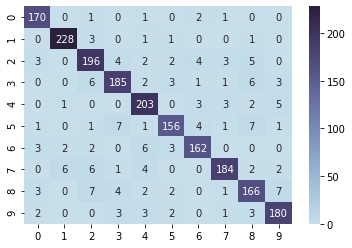


Experts used by the gate for classification of each digit


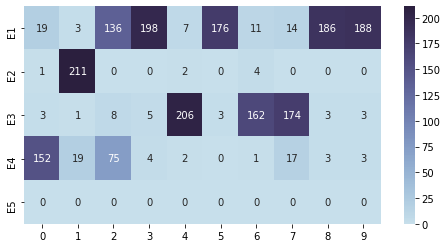

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_1 = 'mnist_scratch'

m = model_1
n_runs = 5
n_run = 1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[0]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
        image_file = generate_plot_file(m, 'conf_mat_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)
        
        image_file = generate_plot_file(m, 'class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()

### Experts selected by the gate for MNIST test data classification, for each digit, by models trained with pre-trained experts trained on 5 different splits of the 10 digits.

In [104]:
# Pre-defined class split among experts
classes_per_expert_list = [[[0,1], [2,5], [3,4], [6,9], [7,8]],
                      [[0,9], [1,4], [2,7], [3,6], [5,8]],
                      [[0,3], [1,2], [4,7], [5,9], [6,8]],
                      [[0,5], [1,9], [2,6], [3,7], [4,8]],
                      [[0,4],[1,8], [2,9], [3,6], [5,7]]]

class_expert_map = []
for cpe in classes_per_expert_list:
    entry = {c[0]:c[1] for c in cpe}
    class_expert_map.append(entry)

Model: mnist_pretrained_gate_prechosen_10_5_models.pt

Split: [[0, 1], [2, 5], [3, 4], [6, 9], [7, 8]]


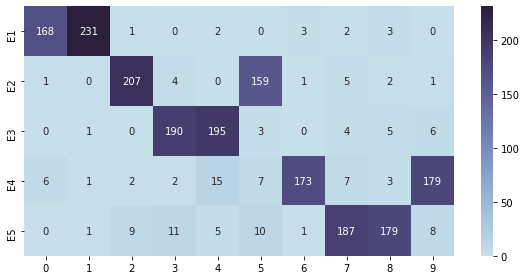


Split: [[0, 9], [1, 4], [2, 7], [3, 6], [5, 8]]


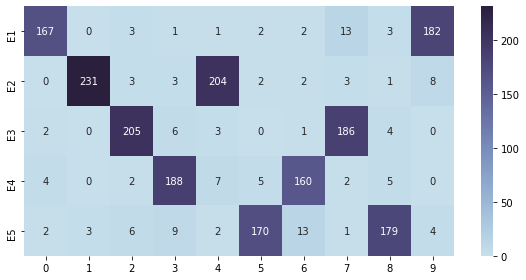


Split: [[0, 3], [1, 2], [4, 7], [5, 9], [6, 8]]


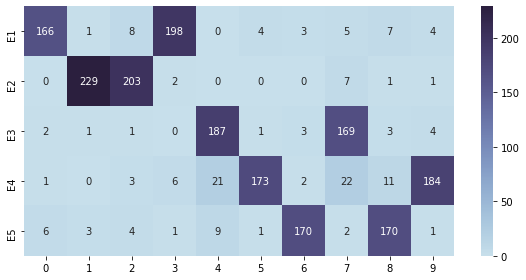


Split: [[0, 5], [1, 9], [2, 6], [3, 7], [4, 8]]


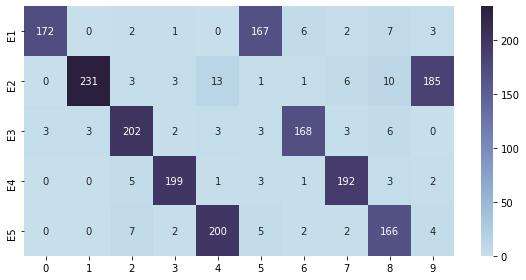


Split: [[0, 4], [1, 8], [2, 9], [3, 6], [5, 7]]


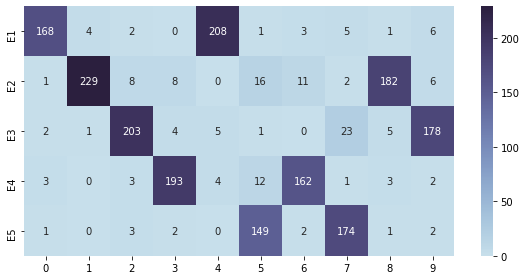

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_4 = 'mnist_pretrained_gate_prechosen'

m = model_4
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    print('\nSplit:', classes_per_expert)
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax1)
            image_file = generate_plot_file(m, 'class_expert_table_'+classes_per_expert_str(classes_per_expert)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            plt.tight_layout()
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

### Training loss comparison, for MNIST dataset, for pre-trained gate, trained on pre-trained and un-trained experts and training experts with default parameter initialization with the same initial parameter initialization as the experts trained from

In [106]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

mnist_pretrained_gate_loss_compare_diff_subsets_10_5_experts.png


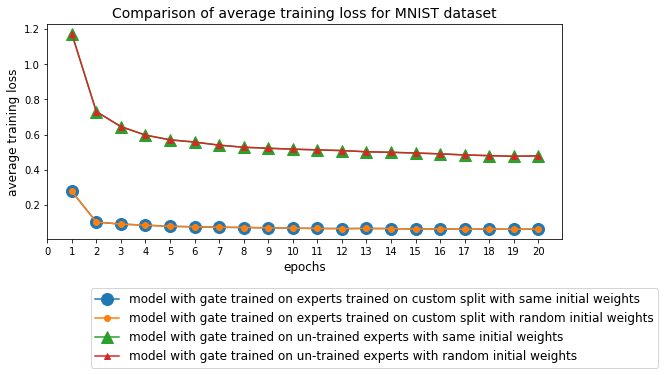

In [110]:
m_key = 'moe_expectation_model'
n_runs = 5
total_experts = 5

model_2 = 'mnist_pretrained_gate_scratch_same_wts'
model_5 = 'mnist_pretrained_gate_prechosen_same_wts'

m1 = model_2
m2 = model_5

plot_file = generate_plot_file(m1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch_10 = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
history_scratch = np.asarray([model[m_key]['experts'][total_experts]['history']['loss'] for model in models_scratch_10])
mean_loss_scratch_same_wts = np.mean(history_scratch, axis=0)

history_prechosen = []
plot_file = generate_plot_file(m2, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    history_prechosen.append(model[m_key]['experts'][total_experts]['history']['loss'])
history_prechosen = np.asarray(history_prechosen)
mean_loss_prechosen_same_wts = np.mean(history_prechosen, axis=0)

model_3 = 'mnist_pretrained_gate_scratch_rand_wts'
model_6 = 'mnist_pretrained_gate_prechosen_rand_wts'


m1 = model_3
m2 = model_6
plot_file = generate_plot_file(m1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch_10 = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
history_scratch = np.asarray([model[m_key]['experts'][total_experts]['history']['loss'] for model in models_scratch_10])
mean_loss_scratch_rand_wts = np.mean(history_scratch, axis=0)

history_prechosen = []
plot_file = generate_plot_file(m2, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    history_prechosen.append(model[m_key]['experts'][total_experts]['history']['loss'])
history_prechosen = np.asarray(history_prechosen)
mean_loss_prechosen_rand_wts = np.mean(history_prechosen, axis=0)

fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

legend_labels = ['model with gate trained on experts trained on custom split with same initial weights', 
                 'model with gate trained on experts trained on custom split with random initial weights',
                 'model with gate trained on un-trained experts with same initial weights',                
                 'model with gate trained on un-trained experts with random initial weights']
ax.plot(range(1, 1+len(mean_loss_prechosen_same_wts)), mean_loss_prechosen_same_wts, marker='o', markersize=12)
ax.plot(range(1, 1+len(mean_loss_prechosen_rand_wts)), mean_loss_prechosen_same_wts, marker='o')
ax.plot(range(1, 1+len(mean_loss_scratch_same_wts)), mean_loss_scratch_rand_wts, marker='^', markersize=12)   
ax.plot(range(1, 1+len(mean_loss_scratch_rand_wts)), mean_loss_scratch_rand_wts, marker='^')   

legend = plt.legend(legend_labels, bbox_to_anchor=(1.2, -0.2), fontsize=12)
legend.set_visible(False)

ax.set_title('Comparison of average training loss for MNIST dataset', fontsize=14)
ax.set_xlabel('epochs', fontsize=12)
ax.set_xticks(range(len(mean_loss_scratch_rand_wts)+1))
ax.set_ylabel('average training loss', fontsize=12)

model = 'mnist_pretrained_gate'
image_file = generate_plot_file(model, 'loss_compare_diff_subsets_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, image_file))
print(image_file)

legend.set_visible(True)
image_file = generate_plot_file(model, 'loss_compare_diff_subsets_legend_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
image_file=os.path.join(fig_path, image_file)
export_legend(legend, image_file)
plt.show()

mnist_pretrained_gate_error_compare_diff_subsets_10_5_experts.png


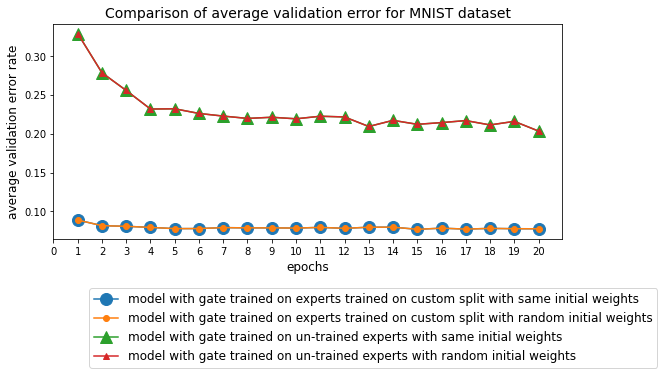

In [111]:
m_key = 'moe_expectation_model'
n_runs = 5
total_experts = 5

model_2 = 'mnist_pretrained_gate_scratch_same_wts'
model_5 = 'mnist_pretrained_gate_prechosen_same_wts'

m1 = model_2
m2 = model_5

plot_file = generate_plot_file(m1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch_10 = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
history_scratch = np.asarray([model[m_key]['experts'][total_experts]['history']['val_accuracy'] for model in models_scratch_10])
mean_acc_scratch_same_wts = np.mean(history_scratch, axis=0)

history_prechosen = []
plot_file = generate_plot_file(m2, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    history_prechosen.append(model[m_key]['experts'][total_experts]['history']['val_accuracy'])
history_prechosen = np.asarray(history_prechosen)
mean_acc_prechosen_same_wts = np.mean(history_prechosen, axis=0)

model_3 = 'mnist_pretrained_gate_scratch_rand_wts'
model_6 = 'mnist_pretrained_gate_prechosen_rand_wts'


m1 = model_3
m2 = model_6
plot_file = generate_plot_file(m1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch_10 = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
history_scratch = np.asarray([model[m_key]['experts'][total_experts]['history']['val_accuracy'] for model in models_scratch_10])
mean_acc_scratch_rand_wts = np.mean(history_scratch, axis=0)

history_prechosen = []
plot_file = generate_plot_file(m2, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
for classes_per_expert, model in zip(classes_per_expert_list, models_prechosen):
    history_prechosen.append(model[m_key]['experts'][total_experts]['history']['val_accuracy'])
history_prechosen = np.asarray(history_prechosen)
mean_acc_prechosen_rand_wts = np.mean(history_prechosen, axis=0)

fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

legend_labels = ['model with gate trained on experts trained on custom split with same initial weights', 
                 'model with gate trained on experts trained on custom split with random initial weights',
                 'model with gate trained on un-trained experts with same initial weights',                
                 'model with gate trained on un-trained experts with random initial weights']
ax.plot(range(1, 1+len(mean_acc_prechosen_same_wts)), 1-mean_acc_prechosen_same_wts, marker='o', markersize=12)
ax.plot(range(1, 1+len(mean_acc_prechosen_rand_wts)), 1-mean_acc_prechosen_same_wts, marker='o')
ax.plot(range(1, 1+len(mean_acc_scratch_same_wts)), 1-mean_acc_scratch_rand_wts, marker='^', markersize=12)   
ax.plot(range(1, 1+len(mean_acc_scratch_rand_wts)), 1-mean_acc_scratch_rand_wts, marker='^')   

legend = plt.legend(legend_labels, bbox_to_anchor=(1.2, -0.2), fontsize=12)
legend.set_visible(False)

ax.set_title('Comparison of average validation error for MNIST dataset', fontsize=14)
ax.set_xlabel('epochs', fontsize=12)
ax.set_xticks(range(len(mean_acc_scratch_rand_wts)+1))
ax.set_ylabel('average validation error rate', fontsize=12)

model = 'mnist_pretrained_gate'
image_file = generate_plot_file(model, 'error_compare_diff_subsets_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, image_file))
print(image_file)

legend.set_visible(True)
image_file = generate_plot_file(model, 'error_compare_diff_subsets_legend_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
image_file=os.path.join(fig_path, image_file)
export_legend(legend, image_file)
plt.show()

### Comparison of average gate probabilities per expert with and without gate coefficientof variation regularization

mnist_with_reg_importance_1.0_10_5_models.pt
mnist_scratch_10_5_5_models.pt

Average gate probability per expert with regualarization


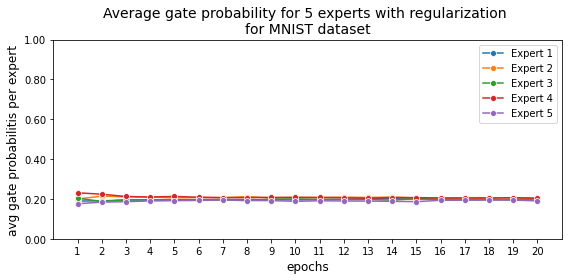


Average gate probability per expert without regualarization


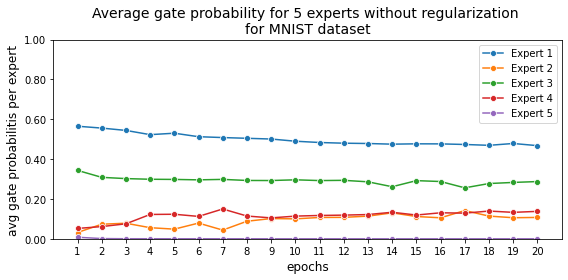

In [114]:
w_importance = 1.0
n_runs = 1
total_experts = 5

model_1 = 'mnist_scratch'
model_7 = 'mnist_with_reg'

plot_file = generate_plot_file(model_7, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_reg = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
print(plot_file)

w_importance = 0.0
n_runs = 5
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_'+str(n_runs)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_unreg = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)[0]
print(plot_file)

for m_name, model in zip(['reg','un_reg'], [models_reg, models_unreg]):
    for e_key, e_val in model.items():
        fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
        if m_name == 'reg':
            print('\nAverage gate probability per expert with regualarization')
            ax.set_title('Average gate probability for ' + str(total_experts)+' experts with regularization \nfor MNIST dataset', fontsize=14)
        else:
            print('\nAverage gate probability per expert without regualarization')
            ax.set_title('Average gate probability for ' + str(total_experts)+' experts without regularization \nfor MNIST dataset', fontsize=14)
        history = e_val['experts'][total_experts]['history']
        gate_prob = np.asarray(history['mean_gate_probability'])
        for i in range(0, total_experts):
            sns.lineplot(x=np.asarray(list(range(1,len(gate_prob)+1))), y=gate_prob[:,i], marker='o', ax=ax)

        
        ax.legend(['Expert '+str(i) for i in range(1, total_experts+1)])
        ax.set_xlabel('epochs', fontsize=12)
        ax.set_xlim(0,len(gate_prob)+1)
        ax.set_ylabel('avg gate probabilitis per expert', fontsize=12)
        ax.set_ylim(0,1)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xticks(range(1, len(gate_prob)+1))
        image_file = generate_plot_file('mnist'+'_'+m_name, 'gate_prob_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        plt.savefig(os.path.join(fig_path, image_file))
        plt.show()
w_importance = 0.0

### Experts used by the gate for classification of each digit with regularization

Model: mnist_with_reg_importance_1.0_10_5_models.pt
something

Experts used by the gate for classification of each digit


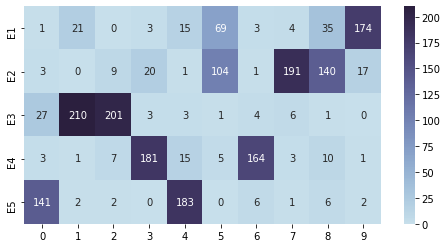

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

total_experts = 5

model_7 = 'mnist_with_reg'
m = model_7
w_importance = 1.0
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
model_reg = torch.load(open(os.path.join(pre_trained_model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model with reg
for e_key, e_val in model_reg.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        print('something')
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax1)
        
        image_file = generate_plot_file(m, 'class_expert_table_reg_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()
w_importance = 0.0